# 1 简单回测

In [33]:
#%%
from datetime import datetime
from importlib import reload
from vnpy.app.portfolio_strategy import BacktestingEngine
from vnpy.trader.constant import Interval
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
symbols = {
    "SHFE": ["CU", "AL", "ZN", "PB", "NI", "SN", "AU", "AG", "RB", "HC", "BU", "RU",],
    "DCE": ["C", "CS", "A", "B", "M", "Y", "P", "BB", "JD", "L", "V", "PP", "J", "JM", "I"],
    "CZCE": ["SR", "CF","PM","WH", "RI", "LR", "JR","OI", "RS", "RM", "TA", "MA", "FG", "SF", "ZC", "SM"], #  "CY", 
}
contract_type = "99"  # 99代表指数合约

In [34]:
def generate_all_vt_symbols(symbols, contract_type):
    """
    合成回测用的vt_symbol列表
    vt_symbol 格式：合约代码.交易所 （ej：AG99.SHFE）
    """
    vt_symbols = []
    for k, v in symbols.items():
        for i in v:
            symbol = i + contract_type + "." + k
            vt_symbols.append(symbol)
    return vt_symbols

In [35]:
generate_all_vt_symbols(symbols, contract_type)

['CU99.SHFE',
 'AL99.SHFE',
 'ZN99.SHFE',
 'PB99.SHFE',
 'NI99.SHFE',
 'SN99.SHFE',
 'AU99.SHFE',
 'AG99.SHFE',
 'RB99.SHFE',
 'HC99.SHFE',
 'BU99.SHFE',
 'RU99.SHFE',
 'C99.DCE',
 'CS99.DCE',
 'A99.DCE',
 'B99.DCE',
 'M99.DCE',
 'Y99.DCE',
 'P99.DCE',
 'BB99.DCE',
 'JD99.DCE',
 'L99.DCE',
 'V99.DCE',
 'PP99.DCE',
 'J99.DCE',
 'JM99.DCE',
 'I99.DCE',
 'SR99.CZCE',
 'CF99.CZCE',
 'PM99.CZCE',
 'WH99.CZCE',
 'RI99.CZCE',
 'LR99.CZCE',
 'JR99.CZCE',
 'OI99.CZCE',
 'RS99.CZCE',
 'RM99.CZCE',
 'TA99.CZCE',
 'MA99.CZCE',
 'FG99.CZCE',
 'SF99.CZCE',
 'ZC99.CZCE',
 'SM99.CZCE']

In [36]:
def set_ratios(num, vt_symbols):
    """
    设置每个vt_symbol的回测参数,最终返回字典格式
    用于设置手续费，滑点，合约规模，price tick
    """
    d = {}
    for i in vt_symbols:
        d[i] = num
    return d

In [37]:
set_ratios(1/10000, generate_all_vt_symbols(symbols, contract_type))

{'CU99.SHFE': 0.0001,
 'AL99.SHFE': 0.0001,
 'ZN99.SHFE': 0.0001,
 'PB99.SHFE': 0.0001,
 'NI99.SHFE': 0.0001,
 'SN99.SHFE': 0.0001,
 'AU99.SHFE': 0.0001,
 'AG99.SHFE': 0.0001,
 'RB99.SHFE': 0.0001,
 'HC99.SHFE': 0.0001,
 'BU99.SHFE': 0.0001,
 'RU99.SHFE': 0.0001,
 'C99.DCE': 0.0001,
 'CS99.DCE': 0.0001,
 'A99.DCE': 0.0001,
 'B99.DCE': 0.0001,
 'M99.DCE': 0.0001,
 'Y99.DCE': 0.0001,
 'P99.DCE': 0.0001,
 'BB99.DCE': 0.0001,
 'JD99.DCE': 0.0001,
 'L99.DCE': 0.0001,
 'V99.DCE': 0.0001,
 'PP99.DCE': 0.0001,
 'J99.DCE': 0.0001,
 'JM99.DCE': 0.0001,
 'I99.DCE': 0.0001,
 'SR99.CZCE': 0.0001,
 'CF99.CZCE': 0.0001,
 'PM99.CZCE': 0.0001,
 'WH99.CZCE': 0.0001,
 'RI99.CZCE': 0.0001,
 'LR99.CZCE': 0.0001,
 'JR99.CZCE': 0.0001,
 'OI99.CZCE': 0.0001,
 'RS99.CZCE': 0.0001,
 'RM99.CZCE': 0.0001,
 'TA99.CZCE': 0.0001,
 'MA99.CZCE': 0.0001,
 'FG99.CZCE': 0.0001,
 'SF99.CZCE': 0.0001,
 'ZC99.CZCE': 0.0001,
 'SM99.CZCE': 0.0001}

In [38]:
def show_result(
    vt_symbols,
    strategy,
    setting={},
    show_chart=True
):
    # 1）创建回测引擎对象
    engine = BacktestingEngine()
    # 2）设置回测参数
    engine.set_parameters(
        vt_symbols=vt_symbols,
        interval=Interval.DAILY,
        start=datetime(2006, 1, 1),
        end=datetime(2020, 12, 30),
        rates=set_ratios(1/1000, vt_symbols),  # 设置每个合约的手续费，字典格式
        slippages=set_ratios(0, vt_symbols),  #滑点，字典格式
        sizes=set_ratios(1, vt_symbols),      #合约规模，字典格式
        priceticks=set_ratios(0.01, vt_symbols), #最小价格跳动，字典格式
        capital=50_000_000,
    )
    # 3）添加策略
    engine.add_strategy(strategy, setting)
    # 4）加载历史数据
    engine.load_data()
    # 5）跑回测，基于事件引擎逐条回放，得到成交记录
    engine.run_backtesting()
    # 6）基于逐日盯市规则和成交记录，得到组合资金曲线
    df = engine.calculate_result()
    # 7）基于资金曲线，计算策略回测指标，如收益率，夏普比率
    engine.calculate_statistics()
    # 8）画图
    if show_chart:
        engine.show_chart()
        
    return df

In [39]:
# 生成可交易合约
all_vt_symbols = generate_all_vt_symbols(symbols, contract_type)

In [41]:
# 加载策略，一键回测
import return10_strategy
reload(return10_strategy)
show_result(all_vt_symbols ,return10_strategy.Return10Strategy, show_chart=True)

2021-02-07 14:37:01.138466	开始加载历史数据
2021-02-07 14:37:01.436499	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:37:01.727500	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:37:02.002498	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-07 14:37:02.228466	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-07 14:37:02.409499	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-07 14:37:02.583496	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-07 14:37:02.855469	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-07 14:37:03.066465	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-07 14:37:03.321499	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-07 14:37:03.508507	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-07 14:37:03.703499	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-07 14:37:04.001496	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:37:04.293499	C99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:37:04.471498	CS99.DCE历史数据加载完成，数据量：1424
2021-02-07 14:37:04.758501	A99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:37:05.048465	B99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:37:05.342471	M99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:37:05.641503	Y99.DCE历史数据加载完成，数据量：3525
202

trade_count  turnover  commission  slippage  trading_pnl  \
date                                                                   
2006-01-03            0       0.0         0.0         0          0.0   
2006-01-04            0       0.0         0.0         0          0.0   
2006-01-05            0       0.0         0.0         0          0.0   
2006-01-08            0       0.0         0.0         0          0.0   
2006-01-09            0       0.0         0.0         0          0.0   
...                 ...       ...         ...       ...          ...   
2020-12-23            0       0.0         0.0         0          0.0   
2020-12-24            0       0.0         0.0         0          0.0   
2020-12-27            0       0.0         0.0         0          0.0   
2020-12-28            0       0.0         0.0         0          0.0   
2020-12-29            0       0.0         0.0         0          0.0   

            holding_pnl    total_pnl      net_pnl       balance    return  \
date                                                                        
2006-01-03       0.0000       0.0000       0.0000  5.000000e+07  0.000000   
2006-01-04       0.0000       0.0000       0.0000  5.000000e+07  0.000000   
2006-01-05       0.0000       0.0000       0.0000  5.000000e+07  0.000000   
2006-01-08       0.0000       0.0000       0.0000  5.000000e+07  0.000000   
2006-01-09       0.0000       0.0000       0.0000  5.000000e+07  0.000000   
...                 ...          ...          ...           ...       ...   
2020-12-23  356301.4300  356301.4300  356301.4300  1.438686e+08  0.002480   
2020-12-24  880185.9418  880185.9418  880185.9418  1.447488e+08  0.006099   
2020-12-27 -591319.3978 -591319.3978 -591319.3978  1.441575e+08 -0.004094   
2020-12-28 -550852.6229 -550852.6229 -550852.6229  1.436066e+08 -0.003829   
2020-12-29  469700.8761  469700.8761  469700.8761  1.440763e+08  0.003265   

               highlevel      drawdown  ddpercent  
date                                               
2006-01-03  5.000000e+07  0.000000e+00   0.000000  
2006-01-04  5.000000e+07  0.000000e+00   0.000000  
2006-01-05  5.000000e+07  0.000000e+00   0.000000  
2006-01-08  5.000000e+07  0.000000e+00   0.000000  
2006-01-09  5.000000e+07  0.000000e+00   0.000000  
...                  ...           ...        ...  
2020-12-23  1.450608e+08 -1.192217e+06  -0.821873  
2020-12-24  1.450608e+08 -3.120306e+05  -0.215103  
2020-12-27  1.450608e+08 -9.033500e+05  -0.622739  
2020-12-28  1.450608e+08 -1.454203e+06  -1.002478  
2020-12-29  1.450608e+08 -9.845018e+05  -0.678682  

[3528 rows x 13 columns]

# 2 分配资金回测

In [42]:
def run_strategy_complite(
    vt_symbols,
    strategy,
    setting={},
    show_chart=False
):
    holding_period = setting["holding_period"] #10
    frames = 0
    for i in range(holding_period):
        # 0, 1, 2, 9
        print(i)
        setting_strategy = {
            "shift_period" : i
        }
        
        setting_strategy.update(setting)
        df = show_result(
            vt_symbols,
            strategy,
            setting_strategy,
            show_chart=False
        )
        frames_mean = frames + df[["balance","net_pnl","commission","slippage","turnover","trade_count"]]

    frames_mean = frames / holding_period    
    engine = BacktestingEngine()
    engine.capital = 50_000_000
    engine.calculate_statistics(frames_mean)
    if show_chart:
        engine.show_chart(frames_mean)

In [43]:
run_strategy_complite(
    all_vt_symbols,
    return10_strategy.Return10Strategy,
    setting={"holding_period": 10},
    show_chart=True
)

0
2021-02-07 14:40:32.314329	开始加载历史数据
2021-02-07 14:40:32.637331	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:40:32.936327	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:40:33.231330	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-07 14:40:33.480298	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-07 14:40:33.673301	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-07 14:40:33.866328	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-07 14:40:34.152327	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-07 14:40:34.366297	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-07 14:40:34.631298	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-07 14:40:34.827330	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-07 14:40:35.021329	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-07 14:40:35.330298	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:40:35.635299	C99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:40:35.820327	CS99.DCE历史数据加载完成，数据量：1424
2021-02-07 14:40:36.129325	A99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:40:36.427300	B99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:40:36.730331	M99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:40:37.033297	Y99.DCE历史数据加载完成，数据量：3525
2

2021-02-07 14:41:02.089304	M99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:41:02.396296	Y99.DCE历史数据加载完成，数据量：3525
2021-02-07 14:41:02.668330	P99.DCE历史数据加载完成，数据量：3103
2021-02-07 14:41:02.864330	BB99.DCE历史数据加载完成，数据量：1669
2021-02-07 14:41:03.063299	JD99.DCE历史数据加载完成，数据量：1689
2021-02-07 14:41:03.336327	L99.DCE历史数据加载完成，数据量：3160
2021-02-07 14:41:03.599296	V99.DCE历史数据加载完成，数据量：2732
2021-02-07 14:41:03.799330	PP99.DCE历史数据加载完成，数据量：1618
2021-02-07 14:41:04.029332	J99.DCE历史数据加载完成，数据量：2289
2021-02-07 14:41:04.239297	JM99.DCE历史数据加载完成，数据量：1834
2021-02-07 14:41:04.446328	I99.DCE历史数据加载完成，数据量：1703
2021-02-07 14:41:04.745330	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-07 14:41:05.039330	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-07 14:41:05.426332	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-07 14:41:05.637328	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-07 14:41:05.855297	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-07 14:41:06.049299	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-07 14:41:06.256329	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-07 14:41:06.478334	OI99.CZCE历史数据加载完成，数

2021-02-07 14:41:31.105330	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-07 14:41:31.314297	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-07 14:41:31.525301	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-07 14:41:31.728297	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-07 14:41:32.012329	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-07 14:41:32.200329	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-07 14:41:32.406297	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-07 14:41:32.591301	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-07 14:41:32.769323	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-07 14:41:32.954298	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-07 14:41:32.954298	所有历史数据加载完成
2021-02-07 14:41:34.853299	逐日盯市盈亏计算完成
2021-02-07 14:41:34.853299	开始计算策略统计指标
2021-02-07 14:41:34.861297	------------------------------
2021-02-07 14:41:34.861297	首个交易日：	2006-01-03
2021-02-07 14:41:34.861297	最后交易日：	2020-12-29
2021-02-07 14:41:34.861297	总交易日：	3528
2021-02-07 14:41:34.861297	盈利交易日：	1814
2021-02-07 14:41:34.861297	亏损交易日：	1687
2021-02-07 14:41:34.861297	起始资金：	50,000,000.00
2021-02-07 14:41:34.861297	结束资金：	97

2021-02-07 14:42:00.129299	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:42:00.430333	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:42:00.725337	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-07 14:42:00.960302	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-07 14:42:01.145301	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-07 14:42:01.322327	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-07 14:42:01.604330	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-07 14:42:01.822295	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-07 14:42:02.087297	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-07 14:42:02.281303	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-07 14:42:02.483328	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-07 14:42:02.782299	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-07 14:42:03.077332	C99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:42:03.264330	CS99.DCE历史数据加载完成，数据量：1424
2021-02-07 14:42:03.561333	A99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:42:03.865298	B99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:42:04.165298	M99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:42:04.467327	Y99.DCE历史数据加载完成，数据量：3525
2021-02-07 14:42:04.742331	P99.DCE历史数据加

2021-02-07 14:42:29.366298	M99.DCE历史数据加载完成，数据量：3528
2021-02-07 14:42:29.670332	Y99.DCE历史数据加载完成，数据量：3525
2021-02-07 14:42:29.943329	P99.DCE历史数据加载完成，数据量：3103
2021-02-07 14:42:30.133328	BB99.DCE历史数据加载完成，数据量：1669
2021-02-07 14:42:30.327329	JD99.DCE历史数据加载完成，数据量：1689
2021-02-07 14:42:30.600331	L99.DCE历史数据加载完成，数据量：3160
2021-02-07 14:42:30.851329	V99.DCE历史数据加载完成，数据量：2732
2021-02-07 14:42:31.041302	PP99.DCE历史数据加载完成，数据量：1618
2021-02-07 14:42:31.269328	J99.DCE历史数据加载完成，数据量：2289
2021-02-07 14:42:31.470329	JM99.DCE历史数据加载完成，数据量：1834
2021-02-07 14:42:31.676299	I99.DCE历史数据加载完成，数据量：1703
2021-02-07 14:42:31.980298	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-07 14:42:32.286327	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-07 14:42:32.504329	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-07 14:42:32.717328	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-07 14:42:32.936328	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-07 14:42:33.131298	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-07 14:42:33.331298	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-07 14:42:33.568327	OI99.CZCE历史数据加载完成，数

# 优化参数

In [44]:
from vnpy.app.cta_strategy.backtesting import OptimizationSetting

In [45]:
op_setting = OptimizationSetting()
op_setting.add_parameter("return_period",5,20,5)
op_setting.add_parameter("holding_period",5,15,5)
op_setting.set_target("sharpe_ratio")
all_settings = op_setting.generate_setting()
all_settings

[{'return_period': 5, 'holding_period': 5},
 {'return_period': 5, 'holding_period': 10},
 {'return_period': 5, 'holding_period': 15},
 {'return_period': 10, 'holding_period': 5},
 {'return_period': 10, 'holding_period': 10},
 {'return_period': 10, 'holding_period': 15},
 {'return_period': 15, 'holding_period': 5},
 {'return_period': 15, 'holding_period': 10},
 {'return_period': 15, 'holding_period': 15},
 {'return_period': 20, 'holding_period': 5},
 {'return_period': 20, 'holding_period': 10},
 {'return_period': 20, 'holding_period': 15}]

In [46]:
op_setting.target_name

'sharpe_ratio'

In [12]:
def optimize(
    target_name,
    vt_symbols,
    strategy,
    setting={},
    show_chart=False
):
    holding_period = setting["holding_period"]
    frames = 0
    for i in range(holding_period):
        print(i)
        setting_strategy = {
            "shift_period": i
        }
        
        setting_strategy.update(setting)
        df = show_result(
            vt_symbols,
            strategy,
            setting_strategy,
            show_chart=False
        )
        frames = frames + df[["balance","net_pnl","commission","slippage","turnover","trade_count"]]

    frames_mean = frames / holding_period    
    engine = BacktestingEngine()
    engine.capital = 50_000_000
    statistics = engine.calculate_statistics(frames_mean)
    if show_chart:
        engine.show_chart(frames_mean)
        
    ## return 
    target_value = statistics[target_name]
    return (str(setting), target_value, statistics)

In [47]:
for setting in all_settings:
    print(setting)

{'return_period': 5, 'holding_period': 5}
{'return_period': 5, 'holding_period': 10}
{'return_period': 5, 'holding_period': 15}
{'return_period': 10, 'holding_period': 5}
{'return_period': 10, 'holding_period': 10}
{'return_period': 10, 'holding_period': 15}
{'return_period': 15, 'holding_period': 5}
{'return_period': 15, 'holding_period': 10}
{'return_period': 15, 'holding_period': 15}
{'return_period': 20, 'holding_period': 5}
{'return_period': 20, 'holding_period': 10}
{'return_period': 20, 'holding_period': 15}


In [14]:
results = []
for setting in all_settings:
    result=optimize(
        op_setting.target_name,
        all_vt_symbols,
        return10_strategy.Return10Strategy,
        setting=setting,        
    )
    results.append(result)

0
2021-02-06 18:48:26.408312	开始加载历史数据
2021-02-06 18:48:26.723314	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:48:26.985312	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:48:27.233313	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:48:27.441302	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:48:27.596314	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:48:27.760281	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:48:28.008310	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:48:28.196311	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:48:28.429279	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:48:28.597309	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:48:28.773310	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:48:29.046309	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:48:29.401283	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:48:29.578310	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:48:29.842309	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:48:30.103310	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:48:30.370279	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:48:30.660309	Y99.DCE历史数据加载完成，数据量：3525
2

2021-02-06 18:48:53.244312	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:48:53.509311	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:48:53.752309	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:48:53.927309	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:48:54.107310	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:48:54.374309	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:48:54.596279	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:48:54.765309	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:48:54.992283	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:48:55.193311	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:48:55.377280	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:48:55.641315	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:48:55.906309	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:48:56.102283	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:48:56.312279	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:48:56.803283	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:48:56.996279	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:48:57.195283	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:48:57.413279	OI99.CZCE历史数据加载完成，数

2021-02-06 18:49:20.631282	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:49:20.820309	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:49:21.007310	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:49:21.291280	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:49:21.581283	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:49:21.751312	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:49:21.951283	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:49:22.121310	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:49:22.274312	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:49:22.437312	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:49:22.437312	所有历史数据加载完成
2021-02-06 18:49:24.151309	逐日盯市盈亏计算完成
2021-02-06 18:49:24.151309	开始计算策略统计指标
2021-02-06 18:49:24.157309	------------------------------
2021-02-06 18:49:24.157309	首个交易日：	2006-01-03
2021-02-06 18:49:24.157309	最后交易日：	2020-12-29
2021-02-06 18:49:24.157309	总交易日：	3528
2021-02-06 18:49:24.157309	盈利交易日：	1717
2021-02-06 18:49:24.157309	亏损交易日：	1789
2021-02-06 18:49:24.157309	起始资金：	50,000,000.00
2021-02-06 18:49:24.157309	结束资金：	45

2021-02-06 18:49:41.929314	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:49:42.194312	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:49:42.465311	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:49:42.673314	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:49:42.859310	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:49:43.061283	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:49:43.252282	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:49:43.451283	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:49:43.655282	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:49:43.867279	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:49:44.066283	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:49:44.328309	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:49:44.496309	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:49:44.697282	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:49:44.861309	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:49:45.038282	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:49:45.204310	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:49:45.204310	所有历史数据加载完成
2021-02-06 18:49:46.953312	逐日盯市盈亏计算完成
2021-02-

2021-02-06 18:50:09.405312	逐日盯市盈亏计算完成
2021-02-06 18:50:09.405312	开始计算策略统计指标
2021-02-06 18:50:09.411310	------------------------------
2021-02-06 18:50:09.412309	首个交易日：	2006-01-03
2021-02-06 18:50:09.412309	最后交易日：	2020-12-29
2021-02-06 18:50:09.412309	总交易日：	3528
2021-02-06 18:50:09.412309	盈利交易日：	1793
2021-02-06 18:50:09.412309	亏损交易日：	1707
2021-02-06 18:50:09.412309	起始资金：	50,000,000.00
2021-02-06 18:50:09.412309	结束资金：	67,749,430.92
2021-02-06 18:50:09.412309	总收益率：	35.50%
2021-02-06 18:50:09.412309	年化收益：	2.41%
2021-02-06 18:50:09.412309	最大回撤: 	-4,001,716.80
2021-02-06 18:50:09.412309	百分比最大回撤: -5.96%
2021-02-06 18:50:09.412309	最长回撤天数: 	260
2021-02-06 18:50:09.412309	总盈亏：	17,749,430.92
2021-02-06 18:50:09.412309	总手续费：	9,729,061.93
2021-02-06 18:50:09.412309	总滑点：	0.00
2021-02-06 18:50:09.412309	总成交金额：	9,729,061,929.85
2021-02-06 18:50:09.412309	总成交笔数：	9451
2021-02-06 18:50:09.412309	日均盈亏：	5,031.02
2021-02-06 18:50:09.412309	日均手续费：	2,757.67
2021-02-06 18:50:09.412309	日均滑点：	0.00
2021-02-06 18:

2021-02-06 18:50:32.453311	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:50:32.716282	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:50:32.963309	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:50:33.193280	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:50:33.370283	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:50:33.562283	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:50:33.830309	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:50:34.021311	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:50:34.282280	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:50:34.451311	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:50:34.627313	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:50:34.891313	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:50:35.201283	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:50:35.377282	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:50:35.649323	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:50:35.914312	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:50:36.179310	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:50:36.457309	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:50:36.720284	P99.DCE历史数据加

2021-02-06 18:50:59.186020	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:50:59.461988	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:50:59.657098	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:50:59.833067	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:51:00.097108	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:51:00.395063	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:51:00.564104	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:51:00.783570	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:51:00.978568	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:51:01.152574	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:51:01.417568	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:51:01.685541	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:51:01.876570	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:51:02.062542	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:51:02.268539	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:51:02.434568	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:51:02.607571	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:51:02.800568	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:51:02.983571	RS99.CZCE历史数据加载完成

2021-02-06 18:51:19.805541	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:51:20.073568	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:51:20.336570	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:51:20.559538	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:51:20.821571	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:51:21.113568	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:51:21.378568	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:51:21.640539	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:51:21.890571	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:51:22.061571	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:51:22.237571	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:51:22.484570	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:51:22.708573	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:51:22.890568	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:51:23.091569	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:51:23.279542	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:51:23.480541	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:51:23.835570	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:51:24.099540	CF99.CZCE历史数据加载完成，数据量：3528

2021-02-06 18:51:45.933569	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:51:46.208541	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:51:46.422539	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:51:46.609540	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:51:46.798565	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:51:46.972570	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:51:47.159542	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:51:47.346568	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:51:47.537542	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:51:47.727574	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:51:47.980542	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:51:48.148569	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:51:48.355543	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:51:48.522568	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:51:48.679539	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:51:48.851569	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:51:48.851569	所有历史数据加载完成
2021-02-06 18:51:50.496572	逐日盯市盈亏计算完成
2021-02-06 18:51:50.497569	开始计算策略统计指标
2021-02-06 18:51:50.50

2021-02-06 18:52:12.887540	逐日盯市盈亏计算完成
2021-02-06 18:52:12.887540	开始计算策略统计指标
2021-02-06 18:52:12.894563	------------------------------
2021-02-06 18:52:12.894563	首个交易日：	2006-01-03
2021-02-06 18:52:12.894563	最后交易日：	2020-12-29
2021-02-06 18:52:12.894563	总交易日：	3528
2021-02-06 18:52:12.894563	盈利交易日：	1786
2021-02-06 18:52:12.894563	亏损交易日：	1715
2021-02-06 18:52:12.894563	起始资金：	50,000,000.00
2021-02-06 18:52:12.894563	结束资金：	63,853,914.72
2021-02-06 18:52:12.894563	总收益率：	27.71%
2021-02-06 18:52:12.894563	年化收益：	1.88%
2021-02-06 18:52:12.894563	最大回撤: 	-5,312,615.07
2021-02-06 18:52:12.894563	百分比最大回撤: -9.49%
2021-02-06 18:52:12.894563	最长回撤天数: 	969
2021-02-06 18:52:12.894563	总盈亏：	13,853,914.72
2021-02-06 18:52:12.894563	总手续费：	6,691,347.86
2021-02-06 18:52:12.894563	总滑点：	0.00
2021-02-06 18:52:12.894563	总成交金额：	6,691,347,862.33
2021-02-06 18:52:12.894563	总成交笔数：	6411
2021-02-06 18:52:12.894563	日均盈亏：	3,926.85
2021-02-06 18:52:12.894563	日均手续费：	1,896.64
2021-02-06 18:52:12.894563	日均滑点：	0.00
2021-02-06 18:

2021-02-06 18:52:35.977542	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:52:36.240542	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:52:36.490571	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:52:36.710539	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:52:36.882542	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:52:37.041568	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:52:37.296541	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:52:37.486567	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:52:37.717540	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:52:37.901539	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:52:38.098542	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:52:38.396541	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:52:38.689542	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:52:38.872541	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:52:39.169542	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:52:39.447542	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:52:39.718538	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:52:40.008542	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:52:40.267566	P99.DCE历史数据加

2021-02-06 18:53:02.920538	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:53:03.180569	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:53:03.351573	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:53:03.538543	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:53:03.805585	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:53:04.047538	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:53:04.226571	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:53:04.442579	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:53:04.635547	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:53:04.820568	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:53:05.097573	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:53:05.369544	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:53:05.575539	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:53:05.767570	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:53:06.217572	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:53:06.393570	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:53:06.574569	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:53:06.782539	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:53:06.976568	RS99.CZCE历史数据加载完成

2021-02-06 18:53:30.011758	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:53:30.220727	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:53:30.477731	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:53:30.660729	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:53:30.867731	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:53:31.059732	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:53:31.234731	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:53:31.404759	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:53:31.404759	所有历史数据加载完成
2021-02-06 18:53:33.020760	逐日盯市盈亏计算完成
2021-02-06 18:53:33.020760	开始计算策略统计指标
2021-02-06 18:53:33.026762	------------------------------
2021-02-06 18:53:33.026762	首个交易日：	2006-01-03
2021-02-06 18:53:33.026762	最后交易日：	2020-12-29
2021-02-06 18:53:33.026762	总交易日：	3528
2021-02-06 18:53:33.027761	盈利交易日：	1795
2021-02-06 18:53:33.027761	亏损交易日：	1698
2021-02-06 18:53:33.027761	起始资金：	50,000,000.00
2021-02-06 18:53:33.027761	结束资金：	70,614,297.45
2021-02-06 18:53:33.027761	总收益率：	41.23%
2021-02-06 18:53:33.027761	年化收益：	2.80%
2021-02-06 18:53:

2021-02-06 18:53:55.858761	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:53:56.125758	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:53:56.379758	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:53:56.618732	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:53:56.788760	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:53:56.965731	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:53:57.226731	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:53:57.429729	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:53:57.665758	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:53:57.854728	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:53:58.060727	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:53:58.348728	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:53:58.649731	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:53:58.810758	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:53:59.076758	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:53:59.365729	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:53:59.633759	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:53:59.894731	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:54:00.161758	P99.DCE历史数据加

2021-02-06 18:54:18.704758	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:54:18.990728	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:54:19.236760	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:54:19.459729	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:54:19.640731	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:54:19.813758	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:54:20.088767	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:54:20.293727	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:54:20.522758	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:54:20.693753	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:54:20.876729	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:54:21.161731	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:54:21.448768	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:54:21.607760	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:54:21.878762	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:54:22.147758	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:54:22.449732	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:54:22.740731	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:54:22.984759	P99.DCE历史数据加

2021-02-06 18:54:45.734731	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:54:45.978755	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:54:46.148746	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:54:46.319758	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:54:46.569761	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:54:46.791763	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:54:46.957761	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:54:47.159760	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:54:47.336760	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:54:47.527731	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:54:47.863759	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:54:48.180727	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:54:48.368743	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:54:48.556761	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:54:48.743757	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:54:48.930731	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:54:49.102758	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:54:49.310731	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:54:49.504757	RS99.CZCE历史数据加载完成

2021-02-06 18:55:06.685758	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:55:06.978731	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:55:07.241758	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:55:07.399758	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:55:07.727758	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:55:08.022731	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:55:08.296761	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:55:08.583731	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:55:08.834758	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:55:09.026731	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:55:09.222731	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:55:09.497731	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:55:09.720758	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:55:09.890758	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:55:10.098729	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:55:10.279760	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:55:10.466731	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:55:10.761731	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:55:11.121758	CF99.CZCE历史数据加载完成，数据量：3528

2021-02-06 18:55:33.487745	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:55:33.777745	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:55:33.995743	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:55:34.207742	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:55:34.420743	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:55:34.586772	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:55:34.775745	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:55:34.964774	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:55:35.169745	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:55:35.380741	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:55:35.628744	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:55:35.793772	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:55:35.993742	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:55:36.159775	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:55:36.317772	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:55:36.498745	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:55:36.498745	所有历史数据加载完成
2021-02-06 18:55:38.259772	逐日盯市盈亏计算完成
2021-02-06 18:55:38.259772	开始计算策略统计指标
2021-02-06 18:55:38.26

2021-02-06 18:56:01.229774	逐日盯市盈亏计算完成
2021-02-06 18:56:01.229774	开始计算策略统计指标
2021-02-06 18:56:01.235777	------------------------------
2021-02-06 18:56:01.235777	首个交易日：	2006-01-03
2021-02-06 18:56:01.235777	最后交易日：	2020-12-29
2021-02-06 18:56:01.236779	总交易日：	3528
2021-02-06 18:56:01.236779	盈利交易日：	1812
2021-02-06 18:56:01.236779	亏损交易日：	1689
2021-02-06 18:56:01.236779	起始资金：	50,000,000.00
2021-02-06 18:56:01.236779	结束资金：	65,782,805.91
2021-02-06 18:56:01.236779	总收益率：	31.57%
2021-02-06 18:56:01.236779	年化收益：	2.15%
2021-02-06 18:56:01.236779	最大回撤: 	-3,392,100.91
2021-02-06 18:56:01.236779	百分比最大回撤: -5.41%
2021-02-06 18:56:01.236779	最长回撤天数: 	597
2021-02-06 18:56:01.236779	总盈亏：	15,782,805.91
2021-02-06 18:56:01.236779	总手续费：	9,818,439.17
2021-02-06 18:56:01.236779	总滑点：	0.00
2021-02-06 18:56:01.236779	总成交金额：	9,818,439,170.76
2021-02-06 18:56:01.236779	总成交笔数：	9538
2021-02-06 18:56:01.236779	日均盈亏：	4,473.58
2021-02-06 18:56:01.236779	日均手续费：	2,783.00
2021-02-06 18:56:01.236779	日均滑点：	0.00
2021-02-06 18:

2021-02-06 18:56:24.015745	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:56:24.292774	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:56:24.559775	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:56:24.786743	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:56:24.986015	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:56:25.161009	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:56:25.430013	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:56:25.643010	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:56:25.883009	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:56:26.052039	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:56:26.474010	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:56:26.783034	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:56:27.079040	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:56:27.238040	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:56:27.498010	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:56:27.757039	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:56:28.033041	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:56:28.290009	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:56:28.531043	P99.DCE历史数据加

2021-02-06 18:56:50.731225	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:56:50.977263	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:56:51.148259	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:56:51.321258	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:56:51.565228	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:56:51.800229	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:56:51.967260	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:56:52.191231	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:56:52.383258	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:56:52.555258	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:56:52.912229	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:56:53.174260	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:56:53.365258	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:56:53.551261	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:56:53.738261	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:56:53.902261	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:56:54.073255	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:56:54.259227	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:56:54.444258	RS99.CZCE历史数据加载完成

2021-02-06 18:57:11.474785	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:57:11.733784	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:57:11.993782	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:57:12.155780	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:57:12.419751	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:57:12.707748	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:57:12.968782	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:57:13.226780	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:57:13.466781	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:57:13.636781	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:57:13.810781	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:57:14.059783	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:57:14.560781	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:57:14.729780	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:57:14.959754	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:57:15.154756	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:57:15.334781	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:57:15.596784	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:57:15.875783	CF99.CZCE历史数据加载完成，数据量：3528

2021-02-06 18:57:37.742202	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:57:38.038202	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:57:38.232231	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:57:38.420231	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:57:38.605231	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:57:38.853234	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:57:39.028200	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:57:39.227229	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:57:39.409230	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:57:39.600228	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:57:39.850226	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:57:40.031202	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:57:40.215229	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:57:40.379229	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:57:40.535229	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:57:40.699229	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:57:40.699229	所有历史数据加载完成
2021-02-06 18:57:42.357228	逐日盯市盈亏计算完成
2021-02-06 18:57:42.357228	开始计算策略统计指标
2021-02-06 18:57:42.36

2021-02-06 18:58:04.572231	逐日盯市盈亏计算完成
2021-02-06 18:58:04.572231	开始计算策略统计指标
2021-02-06 18:58:04.579198	------------------------------
2021-02-06 18:58:04.579198	首个交易日：	2006-01-03
2021-02-06 18:58:04.579198	最后交易日：	2020-12-29
2021-02-06 18:58:04.579198	总交易日：	3528
2021-02-06 18:58:04.579198	盈利交易日：	1820
2021-02-06 18:58:04.579198	亏损交易日：	1682
2021-02-06 18:58:04.579198	起始资金：	50,000,000.00
2021-02-06 18:58:04.579198	结束资金：	75,936,180.16
2021-02-06 18:58:04.579198	总收益率：	51.87%
2021-02-06 18:58:04.579198	年化收益：	3.53%
2021-02-06 18:58:04.579198	最大回撤: 	-3,351,390.80
2021-02-06 18:58:04.579198	百分比最大回撤: -5.34%
2021-02-06 18:58:04.579198	最长回撤天数: 	971
2021-02-06 18:58:04.579198	总盈亏：	25,936,180.16
2021-02-06 18:58:04.579198	总手续费：	6,637,997.01
2021-02-06 18:58:04.579198	总滑点：	0.00
2021-02-06 18:58:04.579198	总成交金额：	6,637,997,014.45
2021-02-06 18:58:04.579198	总成交笔数：	6454
2021-02-06 18:58:04.579198	日均盈亏：	7,351.52
2021-02-06 18:58:04.579198	日均手续费：	1,881.52
2021-02-06 18:58:04.579198	日均滑点：	0.00
2021-02-06 18:

2021-02-06 18:58:27.193228	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:58:27.484202	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:58:27.732231	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:58:27.933231	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:58:28.099231	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:58:28.256199	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:58:28.501202	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:58:28.716198	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:58:28.949228	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:58:29.122229	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:58:29.300229	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:58:29.581228	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:58:29.861229	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:58:30.033230	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:58:30.298233	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:58:30.562201	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:58:30.822232	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:58:31.089231	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:58:31.350231	P99.DCE历史数据加

2021-02-06 18:58:54.161228	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:58:54.451232	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 18:58:54.711202	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 18:58:54.944204	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 18:58:55.262202	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 18:58:55.563231	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 18:58:55.780203	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 18:58:56.045201	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 18:58:56.271201	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 18:58:56.477199	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 18:58:56.800230	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 18:58:57.335232	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 18:58:57.583199	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 18:58:57.820201	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:58:58.054198	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 18:58:58.287203	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 18:58:58.475200	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 18:58:58.667231	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:58:58.855232	RS99.CZCE历史数据加载完成

2021-02-06 18:59:25.455061	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 18:59:25.652099	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:59:25.866766	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 18:59:26.180770	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 18:59:26.354310	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 18:59:26.571357	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 18:59:26.764840	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:59:26.954847	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 18:59:27.159822	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 18:59:27.159822	所有历史数据加载完成
2021-02-06 18:59:29.111977	逐日盯市盈亏计算完成
2021-02-06 18:59:29.112976	开始计算策略统计指标
2021-02-06 18:59:29.124978	------------------------------
2021-02-06 18:59:29.125977	首个交易日：	2006-01-03
2021-02-06 18:59:29.125977	最后交易日：	2020-12-29
2021-02-06 18:59:29.125977	总交易日：	3528
2021-02-06 18:59:29.125977	盈利交易日：	1853
2021-02-06 18:59:29.125977	亏损交易日：	1641
2021-02-06 18:59:29.125977	起始资金：	50,000,000.00
2021-02-06 18:59:29.125977	结束资金：	72,094,051.31
2021-02-06 18:59:29.125977	总收益率：	44.19%
20

2021-02-06 18:59:52.434100	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:59:52.699101	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:59:52.944101	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 18:59:53.148101	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 18:59:53.320074	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:59:53.481103	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 18:59:53.720103	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 18:59:53.925070	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 18:59:54.152100	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 18:59:54.323657	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 18:59:54.503629	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 18:59:54.769629	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 18:59:55.051520	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:59:55.263762	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 18:59:55.539545	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:59:55.827591	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:59:56.128334	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 18:59:56.431385	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 18:59:56.676670	P99.DCE历史数据加

2021-02-06 19:00:19.491623	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:00:19.735622	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:00:19.905621	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:00:20.082619	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:00:20.331619	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:00:20.553622	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:00:20.727588	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:00:20.931622	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:00:21.114590	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:00:21.307590	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:00:21.597588	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:00:21.954621	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:00:22.151621	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:00:22.337589	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:00:22.524619	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:00:22.689620	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:00:22.863619	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:00:23.052619	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:00:23.244621	RS99.CZCE历史数据加载完成

2021-02-06 19:01:08.032418	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:01:08.355486	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:01:08.630636	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:01:08.833977	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:01:09.030056	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:01:09.255268	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:01:09.447264	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:01:09.622294	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:01:09.908266	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:01:10.139627	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:01:10.396094	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:01:10.738580	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 19:01:10.930417	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 19:01:11.181302	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 19:01:11.396423	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:01:11.563423	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 19:01:11.735455	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:01:11.735455	所有历史数据加载完成
2021-02-06 19:01:13.368438	逐日盯市盈亏计算完成
2021-02-

2021-02-06 19:01:36.118489	逐日盯市盈亏计算完成
2021-02-06 19:01:36.118489	开始计算策略统计指标
2021-02-06 19:01:36.124489	------------------------------
2021-02-06 19:01:36.125489	首个交易日：	2006-01-03
2021-02-06 19:01:36.125489	最后交易日：	2020-12-29
2021-02-06 19:01:36.125489	总交易日：	3528
2021-02-06 19:01:36.125489	盈利交易日：	1826
2021-02-06 19:01:36.125489	亏损交易日：	1674
2021-02-06 19:01:36.125489	起始资金：	50,000,000.00
2021-02-06 19:01:36.125489	结束资金：	75,043,574.69
2021-02-06 19:01:36.125489	总收益率：	50.09%
2021-02-06 19:01:36.125489	年化收益：	3.41%
2021-02-06 19:01:36.125489	最大回撤: 	-6,062,269.79
2021-02-06 19:01:36.125489	百分比最大回撤: -9.22%
2021-02-06 19:01:36.125489	最长回撤天数: 	432
2021-02-06 19:01:36.125489	总盈亏：	25,043,574.69
2021-02-06 19:01:36.125489	总手续费：	7,766,123.59
2021-02-06 19:01:36.125489	总滑点：	0.00
2021-02-06 19:01:36.125489	总成交金额：	7,766,123,585.66
2021-02-06 19:01:36.125489	总成交笔数：	9293
2021-02-06 19:01:36.125489	日均盈亏：	7,098.52
2021-02-06 19:01:36.125489	日均手续费：	2,201.28
2021-02-06 19:01:36.125489	日均滑点：	0.00
2021-02-06 19:

2021-02-06 19:01:59.206283	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:01:59.474327	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:01:59.739299	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:01:59.944301	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:02:00.333907	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:02:00.493816	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:02:00.731813	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:02:00.921814	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:02:01.171783	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:02:01.368787	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:02:01.546622	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:02:01.809591	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:02:02.075616	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:02.246594	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:02:02.523589	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:02.789622	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:03.145618	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:03.431621	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:02:03.718621	P99.DCE历史数据加

2021-02-06 19:02:26.539214	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:02:26.844481	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:02:27.035644	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:02:27.216923	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:02:27.462924	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:02:27.699483	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:02:27.895998	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:02:28.107089	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:02:28.311088	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:02:28.723087	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:02:28.995087	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:02:29.270090	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:02:29.475087	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:02:29.663103	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:02:29.858093	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:02:30.039113	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:02:30.212118	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:02:30.404089	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:02:30.591088	RS99.CZCE历史数据加载完成

2021-02-06 19:02:48.202060	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:02:48.466087	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:02:48.734060	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:48.894087	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:02:49.185060	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:49.453058	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:49.944087	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:02:50.212056	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:02:50.468057	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:02:50.648055	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:02:50.834087	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:02:51.089087	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:02:51.314087	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:02:51.498058	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:02:51.717060	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:02:51.896087	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:02:52.073055	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:02:52.338087	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:02:52.600086	CF99.CZCE历史数据加载完成，数据量：3528

2021-02-06 19:03:14.667071	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:03:14.939071	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:03:15.143069	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:03:15.329099	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:03:15.526071	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:03:15.701071	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:03:15.889071	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:03:16.075097	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:03:16.264097	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:03:16.679100	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:03:16.928071	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 19:03:17.097096	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 19:03:17.281098	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 19:03:17.453069	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:03:17.619066	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 19:03:17.785100	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:03:17.785100	所有历史数据加载完成
2021-02-06 19:03:19.358068	逐日盯市盈亏计算完成
2021-02-06 19:03:19.358068	开始计算策略统计指标
2021-02-06 19:03:19.36

2021-02-06 19:03:41.852100	逐日盯市盈亏计算完成
2021-02-06 19:03:41.852100	开始计算策略统计指标
2021-02-06 19:03:41.859099	------------------------------
2021-02-06 19:03:41.859099	首个交易日：	2006-01-03
2021-02-06 19:03:41.859099	最后交易日：	2020-12-29
2021-02-06 19:03:41.859099	总交易日：	3528
2021-02-06 19:03:41.859099	盈利交易日：	1806
2021-02-06 19:03:41.859099	亏损交易日：	1695
2021-02-06 19:03:41.859099	起始资金：	50,000,000.00
2021-02-06 19:03:41.859099	结束资金：	65,536,575.31
2021-02-06 19:03:41.859099	总收益率：	31.07%
2021-02-06 19:03:41.859099	年化收益：	2.11%
2021-02-06 19:03:41.859099	最大回撤: 	-6,141,854.64
2021-02-06 19:03:41.859099	百分比最大回撤: -8.83%
2021-02-06 19:03:41.859099	最长回撤天数: 	987
2021-02-06 19:03:41.859099	总盈亏：	15,536,575.31
2021-02-06 19:03:41.859099	总手续费：	6,607,148.43
2021-02-06 19:03:41.859099	总滑点：	0.00
2021-02-06 19:03:41.859099	总成交金额：	6,607,148,430.32
2021-02-06 19:03:41.859099	总成交笔数：	6450
2021-02-06 19:03:41.859099	日均盈亏：	4,403.79
2021-02-06 19:03:41.859099	日均手续费：	1,872.77
2021-02-06 19:03:41.859099	日均滑点：	0.00
2021-02-06 19:

2021-02-06 19:04:04.752659	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:04:05.025686	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:04:05.288656	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:04:05.519659	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:04:05.683692	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:04:05.850659	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:04:06.099656	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:04:06.291688	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:04:06.532689	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:04:06.706688	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:04:06.891656	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:04:07.170659	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:04:07.447688	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:04:07.609689	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:04:07.873686	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:04:08.163660	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:04:08.427656	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:04:08.711659	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:04:09.196657	P99.DCE历史数据加

2021-02-06 19:04:31.417032	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:04:31.658035	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:04:31.830033	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:04:32.023005	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:04:32.294032	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:04:32.520002	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:04:32.691035	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:04:32.898033	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:04:33.090032	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:04:33.269032	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:04:33.545033	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:04:33.908006	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:04:34.122033	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:04:34.321033	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:04:34.520033	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:04:34.686030	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:04:34.908005	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:04:35.128003	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:04:35.319006	RS99.CZCE历史数据加载完成

2021-02-06 19:04:57.699022	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:04:57.909989	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:04:58.098020	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:04:58.352025	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 19:04:58.519020	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 19:04:58.718993	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 19:04:58.880991	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:04:59.048993	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 19:04:59.223020	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:04:59.223020	所有历史数据加载完成
2021-02-06 19:05:00.787035	逐日盯市盈亏计算完成
2021-02-06 19:05:00.787035	开始计算策略统计指标
2021-02-06 19:05:00.793035	------------------------------
2021-02-06 19:05:00.793035	首个交易日：	2006-01-03
2021-02-06 19:05:00.793035	最后交易日：	2020-12-29
2021-02-06 19:05:00.794037	总交易日：	3528
2021-02-06 19:05:00.794037	盈利交易日：	1832
2021-02-06 19:05:00.794037	亏损交易日：	1661
2021-02-06 19:05:00.794037	起始资金：	50,000,000.00
2021-02-06 19:05:00.794037	结束资金：	69,992,344.23
2021-02-06 19:05:00.794037	总收益率：	39.98%
20

2021-02-06 19:05:25.852824	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:05:26.113818	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:05:26.379822	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:05:26.606794	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:05:26.765822	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:05:26.935794	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:05:27.196822	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:05:27.386824	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:05:27.612824	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:05:27.781792	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:05:27.954823	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:05:28.228795	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:05:28.498824	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:28.726826	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:05:29.018821	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:29.318794	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:29.611821	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:29.873791	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:05:30.147794	P99.DCE历史数据加

2021-02-06 19:05:48.422817	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:05:48.701842	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:05:48.972845	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:05:49.175842	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:05:49.331843	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:05:49.494845	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:05:49.754812	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:05:49.947816	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:05:50.175843	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:05:50.348814	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:05:50.535844	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:05:50.798845	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:05:51.085844	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:51.266816	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:05:51.533813	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:51.802846	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:52.073845	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:05:52.336847	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:05:52.590842	P99.DCE历史数据加

2021-02-06 19:06:15.386102	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:06:15.626160	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:06:15.807139	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:06:15.990160	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:06:16.256158	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:06:16.482184	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:06:16.692159	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:06:16.929707	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:06:17.127737	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:06:17.301306	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:06:17.605296	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:06:17.877883	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:06:18.089900	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:06:18.282754	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:06:18.492770	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:06:18.659902	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:06:18.845424	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:06:19.317640	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:06:19.511683	RS99.CZCE历史数据加载完成

2021-02-06 19:06:36.976136	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:06:37.258169	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:06:37.522168	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:06:37.685167	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:06:37.967137	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:06:38.237135	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:06:38.553138	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:06:38.846166	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:06:39.090164	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:06:39.266167	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:06:39.439167	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:06:39.689168	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:06:39.922137	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:06:40.103168	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:06:40.309140	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:06:40.503167	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:06:40.680162	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:06:40.966166	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:06:41.231170	CF99.CZCE历史数据加载完成，数据量：3528

2021-02-06 19:07:03.540198	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:07:03.827199	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:07:04.028201	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:07:04.236172	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:07:04.434199	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:07:04.600199	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:07:04.772177	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:07:05.206202	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:07:05.416170	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:07:05.600201	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:07:05.852168	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 19:07:06.021180	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 19:07:06.231201	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 19:07:06.413198	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:07:06.568198	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 19:07:06.730202	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:07:06.731169	所有历史数据加载完成
2021-02-06 19:07:08.495172	逐日盯市盈亏计算完成
2021-02-06 19:07:08.495172	开始计算策略统计指标
2021-02-06 19:07:08.50

2021-02-06 19:07:31.158652	逐日盯市盈亏计算完成
2021-02-06 19:07:31.159650	开始计算策略统计指标
2021-02-06 19:07:31.166646	------------------------------
2021-02-06 19:07:31.166646	首个交易日：	2006-01-03
2021-02-06 19:07:31.166646	最后交易日：	2020-12-29
2021-02-06 19:07:31.166646	总交易日：	3528
2021-02-06 19:07:31.166646	盈利交易日：	1835
2021-02-06 19:07:31.166646	亏损交易日：	1666
2021-02-06 19:07:31.166646	起始资金：	50,000,000.00
2021-02-06 19:07:31.166646	结束资金：	70,307,832.63
2021-02-06 19:07:31.166646	总收益率：	40.62%
2021-02-06 19:07:31.166646	年化收益：	2.76%
2021-02-06 19:07:31.166646	最大回撤: 	-6,220,500.52
2021-02-06 19:07:31.166646	百分比最大回撤: -8.91%
2021-02-06 19:07:31.166646	最长回撤天数: 	667
2021-02-06 19:07:31.166646	总盈亏：	20,307,832.63
2021-02-06 19:07:31.166646	总手续费：	6,652,913.47
2021-02-06 19:07:31.166646	总滑点：	0.00
2021-02-06 19:07:31.166646	总成交金额：	6,652,913,466.78
2021-02-06 19:07:31.166646	总成交笔数：	9269
2021-02-06 19:07:31.166646	日均盈亏：	5,756.19
2021-02-06 19:07:31.166646	日均手续费：	1,885.75
2021-02-06 19:07:31.166646	日均滑点：	0.00
2021-02-06 19:

2021-02-06 19:07:53.917265	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:07:54.450265	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:07:54.707292	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:07:54.911293	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:07:55.086266	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:07:55.246261	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:07:55.490293	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:07:55.697263	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:07:55.929292	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:07:56.102295	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:07:56.279294	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:07:56.560266	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:07:56.823292	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:07:56.983292	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:07:57.336263	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:07:57.599295	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:07:57.870264	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:07:58.142292	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:07:58.384295	P99.DCE历史数据加

2021-02-06 19:08:20.348293	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:08:20.599263	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:08:20.779294	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:08:20.952294	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:08:21.195292	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:08:21.421289	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:08:21.589263	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:08:21.796295	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:08:21.978295	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:08:22.168263	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:08:22.447264	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:08:22.715292	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:08:22.906294	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:08:23.095292	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:08:23.281295	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:08:23.447294	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:08:23.625265	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:08:24.097293	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:08:24.314262	RS99.CZCE历史数据加载完成

2021-02-06 19:08:41.352266	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:08:41.649294	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:08:41.918295	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:08:42.079296	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:08:42.353288	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:08:42.630262	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:08:42.894294	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:08:43.183294	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:08:43.431261	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:08:43.624266	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:08:43.804293	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:08:44.049263	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:08:44.273295	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:08:44.455262	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:08:44.664292	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:08:44.854295	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:08:45.038293	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:08:45.298294	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:08:45.561297	CF99.CZCE历史数据加载完成，数据量：3528

2021-02-06 19:09:08.142823	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:09:08.455646	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:09:08.664614	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:09:08.856614	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:09:09.047646	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:09:09.212694	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:09:09.383707	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:09:09.591680	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:09:09.800675	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:09:09.994721	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:09:10.273551	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 19:09:10.456690	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 19:09:10.669836	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 19:09:10.849869	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:09:11.033868	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 19:09:11.195841	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:09:11.195841	所有历史数据加载完成
2021-02-06 19:09:13.011326	逐日盯市盈亏计算完成
2021-02-06 19:09:13.011326	开始计算策略统计指标
2021-02-06 19:09:13.01

2021-02-06 19:09:39.162969	逐日盯市盈亏计算完成
2021-02-06 19:09:39.163940	开始计算策略统计指标
2021-02-06 19:09:39.169602	------------------------------
2021-02-06 19:09:39.169602	首个交易日：	2006-01-03
2021-02-06 19:09:39.169602	最后交易日：	2020-12-29
2021-02-06 19:09:39.169602	总交易日：	3528
2021-02-06 19:09:39.169602	盈利交易日：	1817
2021-02-06 19:09:39.169602	亏损交易日：	1685
2021-02-06 19:09:39.169602	起始资金：	50,000,000.00
2021-02-06 19:09:39.169602	结束资金：	72,798,042.30
2021-02-06 19:09:39.169602	总收益率：	45.60%
2021-02-06 19:09:39.169602	年化收益：	3.10%
2021-02-06 19:09:39.169602	最大回撤: 	-6,884,942.93
2021-02-06 19:09:39.169602	百分比最大回撤: -9.43%
2021-02-06 19:09:39.169602	最长回撤天数: 	718
2021-02-06 19:09:39.169602	总盈亏：	22,798,042.30
2021-02-06 19:09:39.169602	总手续费：	5,567,479.84
2021-02-06 19:09:39.169602	总滑点：	0.00
2021-02-06 19:09:39.170603	总成交金额：	5,567,479,837.71
2021-02-06 19:09:39.170603	总成交笔数：	6363
2021-02-06 19:09:39.170603	日均盈亏：	6,462.03
2021-02-06 19:09:39.170603	日均手续费：	1,578.08
2021-02-06 19:09:39.170603	日均滑点：	0.00
2021-02-06 19:

2021-02-06 19:10:03.795818	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:10:04.094692	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:10:04.377253	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:10:04.611630	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:10:04.778106	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:10:04.958238	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:10:05.215144	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:10:05.410726	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:10:05.677907	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:10:05.854588	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:10:06.053239	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:10:06.347021	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:10:06.653645	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:10:06.886541	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:10:07.209554	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:10:07.524286	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:10:07.846561	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:10:08.163700	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:10:08.495163	P99.DCE历史数据加

2021-02-06 19:10:32.328698	Y99.DCE历史数据加载完成，数据量：3525
2021-02-06 19:10:32.599424	P99.DCE历史数据加载完成，数据量：3103
2021-02-06 19:10:32.788406	BB99.DCE历史数据加载完成，数据量：1669
2021-02-06 19:10:32.978493	JD99.DCE历史数据加载完成，数据量：1689
2021-02-06 19:10:33.242632	L99.DCE历史数据加载完成，数据量：3160
2021-02-06 19:10:33.489995	V99.DCE历史数据加载完成，数据量：2732
2021-02-06 19:10:33.666539	PP99.DCE历史数据加载完成，数据量：1618
2021-02-06 19:10:33.898210	J99.DCE历史数据加载完成，数据量：2289
2021-02-06 19:10:34.091968	JM99.DCE历史数据加载完成，数据量：1834
2021-02-06 19:10:34.269614	I99.DCE历史数据加载完成，数据量：1703
2021-02-06 19:10:34.549726	SR99.CZCE历史数据加载完成，数据量：3526
2021-02-06 19:10:34.828585	CF99.CZCE历史数据加载完成，数据量：3528
2021-02-06 19:10:35.037328	PM99.CZCE历史数据加载完成，数据量：2108
2021-02-06 19:10:35.241296	WH99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:10:35.689722	RI99.CZCE历史数据加载完成，数据量：1988
2021-02-06 19:10:35.861722	LR99.CZCE历史数据加载完成，数据量：1532
2021-02-06 19:10:36.066502	JR99.CZCE历史数据加载完成，数据量：1683
2021-02-06 19:10:36.276679	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:10:36.465339	RS99.CZCE历史数据加载完成

2021-02-06 19:10:59.997448	OI99.CZCE历史数据加载完成，数据量：1994
2021-02-06 19:11:00.191314	RS99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:11:00.391739	RM99.CZCE历史数据加载完成，数据量：1884
2021-02-06 19:11:00.679927	TA99.CZCE历史数据加载完成，数据量：3303
2021-02-06 19:11:00.862581	MA99.CZCE历史数据加载完成，数据量：1547
2021-02-06 19:11:01.081290	FG99.CZCE历史数据加载完成，数据量：1902
2021-02-06 19:11:01.282288	SF99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:11:01.510129	ZC99.CZCE历史数据加载完成，数据量：1331
2021-02-06 19:11:01.700973	SM99.CZCE历史数据加载完成，数据量：1510
2021-02-06 19:11:01.700973	所有历史数据加载完成
2021-02-06 19:11:03.693315	逐日盯市盈亏计算完成
2021-02-06 19:11:03.694310	开始计算策略统计指标
2021-02-06 19:11:03.702341	------------------------------
2021-02-06 19:11:03.702341	首个交易日：	2006-01-03
2021-02-06 19:11:03.702341	最后交易日：	2020-12-29
2021-02-06 19:11:03.702341	总交易日：	3528
2021-02-06 19:11:03.702341	盈利交易日：	1796
2021-02-06 19:11:03.702341	亏损交易日：	1698
2021-02-06 19:11:03.702341	起始资金：	50,000,000.00
2021-02-06 19:11:03.702341	结束资金：	65,227,498.96
2021-02-06 19:11:03.702341	总收益率：	30.45%
20

NameError: name 'results' is not defined

In [16]:
return_periods = []
holding_periods = []
rates = []
results.sort(reverse=True, key=lambda result: result[1])
for value in results:
    msg = f"参数：{value[0]}, 目标：{value[1]}"
    print(msg)
    return_periods.append(eval(value[0])["return_period"])
    holding_periods.append(eval(value[0])["holding_period"])
    rates.append(value[1])

参数：{'return_period': 10, 'holding_period': 10}, 目标：0.7634195546349473
参数：{'return_period': 5, 'holding_period': 15}, 目标：0.7554029409566378
参数：{'return_period': 15, 'holding_period': 10}, 目标：0.7376291001363258
参数：{'return_period': 15, 'holding_period': 5}, 目标：0.7235409338941688
参数：{'return_period': 5, 'holding_period': 10}, 目标：0.700655064060142
参数：{'return_period': 10, 'holding_period': 15}, 目标：0.6874902258172957
参数：{'return_period': 10, 'holding_period': 5}, 目标：0.6729012411770096
参数：{'return_period': 20, 'holding_period': 10}, 目标：0.6244952933050354
参数：{'return_period': 20, 'holding_period': 5}, 目标：0.6193573636915239
参数：{'return_period': 15, 'holding_period': 15}, 目标：0.6088586392809364
参数：{'return_period': 20, 'holding_period': 15}, 目标：0.5240460486473384
参数：{'return_period': 5, 'holding_period': 5}, 目标：-0.05290945203557836


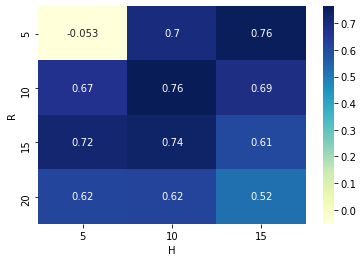

In [25]:
df = pd.DataFrame()
df["R"] = return_periods
df["H"] = holding_periods
df["sharpe"] = rates
df_wide=df.pivot_table( index='R', columns='H', values='sharpe' )
sns.heatmap( df_wide, cmap="YlGnBu", annot=True)
plt.show()